# FloodML Model Evaluation Notebook

This notebook demonstrates the Machine Learning model used in FloodML for flood classification and reports key performance metrics.

- Dataset: `FloodML-master/training/final_data.csv`
- Target label: `class` (0 = Safe, 1 = Unsafe)
- Model: RandomForestClassifier (n_estimators=50, criterion='entropy', random_state=0)


In [3]:
# Install dependencies if running in a fresh environment (optional)
# %pip install -q scikit-learn pandas numpy matplotlib seaborn

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report,
    roc_auc_score,
    roc_curve
)
from sklearn.ensemble import RandomForestClassifier
import pickle

# Paths
DATA_PATH = os.path.join('FloodML-master', 'training', 'final_data.csv')
MODEL_PATH = os.path.join('FloodML-master', 'model.pickle')

# Load dataset
raw = pd.read_csv(DATA_PATH)
print(f"Dataset shape: {raw.shape}")
raw.head()


Dataset shape: (5040, 7)


,temp,max_temp,wind_speed,cloudcover,precip,humidity,class
0,29.90,37.00,23.00,58.60,146.00,83.86,1
1,93.04,82.41,63.44,102.42,192.07,129.30,1
2,87.13,98.82,72.29,122.12,191.80,142.25,1
3,92.12,72.39,73.84,96.50,196.53,150.42,1
4,92.64,76.03,67.13,92.61,191.76,126.61,1


In [4]:
# Split features and target
assert 'class' in raw.columns, "Expected 'class' column as target label"

y = raw['class']
X = raw.drop(columns=['class'])

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(X_train.shape, X_test.shape)


(4032, 6) (1008, 6)


In [6]:
# Load the saved model if available; otherwise train a fresh one for evaluation
if os.path.exists(MODEL_PATH):
    with open(MODEL_PATH, 'rb') as f:
        model = pickle.load(f)
    print("Loaded existing model from:", MODEL_PATH)
else:
    print("Model not found. Training a new RandomForestClassifier for evaluation...")
    model = RandomForestClassifier(n_estimators=50, criterion='entropy', random_state=0)
    model.fit(X_train, y_train)

# Evaluate on test set
y_pred = model.predict(X_test)

metrics = {
    'Accuracy': accuracy_score(y_test, y_pred),
    'Precision (macro)': precision_score(y_test, y_pred, average='macro', zero_division=0),
    'Recall (macro)': recall_score(y_test, y_pred, average='macro', zero_division=0),
    'F1-score (macro)': f1_score(y_test, y_pred, average='macro', zero_division=0),
}

pd.DataFrame(metrics, index=['Score']).T


Loaded existing model from: FloodML-master\model.pickle


,Score
Accuracy,0.995040
Precision (macro),0.993947
Recall (macro),0.995833
F1-score (macro),0.994863


              precision    recall  f1-score   support

           0     0.9879    1.0000    0.9939       408
           1     1.0000    0.9917    0.9958       600

    accuracy                         0.9950      1008
   macro avg     0.9939    0.9958    0.9949      1008
weighted avg     0.9951    0.9950    0.9950      1008



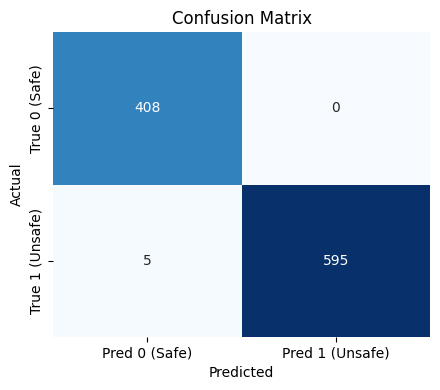

In [7]:
# Detailed classification report and confusion matrix
print(classification_report(y_test, y_pred, digits=4))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(4.5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Pred 0 (Safe)', 'Pred 1 (Unsafe)'],
            yticklabels=['True 0 (Safe)', 'True 1 (Unsafe)'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()


ROC-AUC: 0.9987


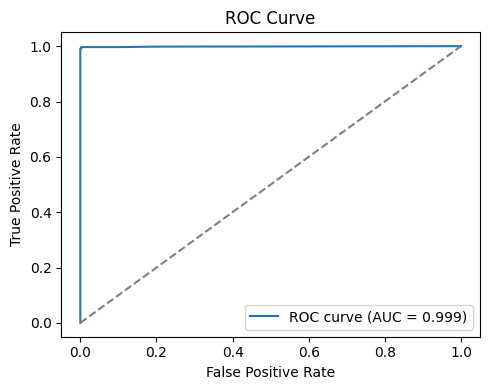

In [8]:
# ROC-AUC (if both classes present)
try:
    # For binary models, decision_function may not exist; use predict_proba
    if hasattr(model, "predict_proba"):
        y_scores = model.predict_proba(X_test)[:, 1]
        auc = roc_auc_score(y_test, y_scores)
        fpr, tpr, _ = roc_curve(y_test, y_scores)

        print(f"ROC-AUC: {auc:.4f}")
        plt.figure(figsize=(5, 4))
        plt.plot(fpr, tpr, label=f"ROC curve (AUC = {auc:.3f})")
        plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve')
        plt.legend(loc='lower right')
        plt.tight_layout()
        plt.show()
    else:
        print("Model does not support predict_proba; skipping ROC-AUC plot.")
except Exception as e:
    print(f"Skipping ROC-AUC: {e}")


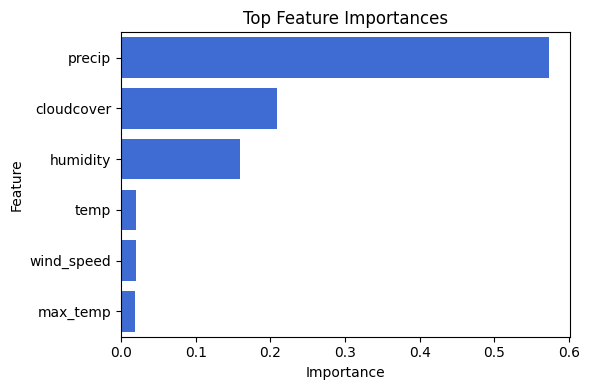

In [9]:
# Feature importance (RandomForest)
if hasattr(model, 'feature_importances_'):
    importances = pd.Series(model.feature_importances_, index=X.columns)
    topk = importances.sort_values(ascending=False).head(15)
    plt.figure(figsize=(6, 4))
    sns.barplot(x=topk.values, y=topk.index, orient='h', color='#2563eb')
    plt.title('Top Feature Importances')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.tight_layout()
    plt.show()
else:
    print('Model does not expose feature_importances_.')
